In [153]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


## Data wrangling and preparation

In [75]:
df_recipes = pd.read_csv("recipes_imputed_manual.csv")
df_similarities = pd.read_csv("similarity_scores.csv")

In [76]:
#the dataset was produced by just 7 unique users
len(df_similarities['user_id'].unique())

7

In [77]:
df_similarities['user_id'].value_counts()

10141    1835
10163    1068
10011     476
10123     341
10145     269
10127     210
10001     139
Name: user_id, dtype: int64

In [78]:
# duplicates in recipe_id
df_recipes['recipe_id'].value_counts().head(3)

197    2
348    2
509    1
Name: recipe_id, dtype: int64

In [79]:
df_recipes = df_recipes.drop_duplicates(subset=["recipe_id"],keep="first")

In [80]:

#there are recipe_ids in the user ratings that don't exist in the dataset

recipe_a = set(df_similarities['recipe_a'].unique().tolist())
recipe_b = set(df_similarities['recipe_b'].unique().tolist())
recipe_aub = recipe_a.union(recipe_b)

recipe_info = set(df_recipes['recipe_id'].unique().tolist())

diff = recipe_aub - recipe_info
print(diff)

df_similarities = df_similarities.drop(df_similarities[df_similarities['recipe_a'].isin(list(diff))].index)
df_similarities = df_similarities.drop(df_similarities[df_similarities['recipe_b'].isin(list(diff))].index)

{585, 530, 322, 534}


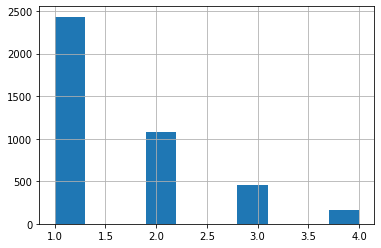

In [81]:
#the dataset is quite unbalanced

df_similarities.score.hist()

In [82]:
df_similarities.score.value_counts()

1    2434
2    1084
3     458
4     168
Name: score, dtype: int64

In [83]:
# quick manual inspection of the dataset

from IPython.display import display

df_high = df_similarities[df_similarities['score']>2].head(1)


for index, row in df_high.iterrows():
    print(f"*" * 100)
    display(df_recipes[df_recipes['recipe_id']==row['recipe_a']])
        
    print(f"-" * 100)
          
    display(df_recipes[df_recipes['recipe_id']==row['recipe_b']])
    print(f"*" * 100)
    

****************************************************************************************************


,recipe_id,country,country_secondary,dish_category,dish_type,diet_type,carbohydrate_base,carbohydrate_category,protein,protein_cut,protein_type,family_friendly,spice_level,prep_time
43,288,China,China,Protein&Veg,Fish & side veg,Fish,Brown Rice,Rice,Whitefish,Basa,Fish & Seafood,No,Mild,35


----------------------------------------------------------------------------------------------------


,recipe_id,country,country_secondary,dish_category,dish_type,diet_type,carbohydrate_base,carbohydrate_category,protein,protein_cut,protein_type,family_friendly,spice_level,prep_time
156,553,Japan,Japan,Stove top / bowl food,Stir Fry,Meat,Wholewheat noodle nests,Noodles,Chicken,Breast Chicken,Poultry & Meat,No,No Spice,30


****************************************************************************************************


In [84]:
# prepare the dataset for metric-learn. All ratings of 3 and above are taken as similar. All below as dissimilar
df_similarities['similar'] = df_similarities['score'].apply(lambda x : 1 if (x > 2) else -1)

In [85]:

df_similarities['similar'].value_counts()

-1    3518
 1     626
Name: similar, dtype: int64

In [86]:
# transform the dataset into dummy values
df_dummy = pd.get_dummies(df_recipes.drop("recipe_id", axis=1))
df_dummy['recipe_id'] = df_recipes['recipe_id']
df_dummy.set_index('recipe_id', inplace=True)

In [87]:
# prepare dataset, construct list of tuples

tuples  = []

for index, row in df_similarities.iterrows():
    tup = []
    tup.append(df_dummy.loc[row['recipe_a']].values.tolist())
    tup.append(df_dummy.loc[row['recipe_b']].values.tolist())
    tuples.append(tup)

In [88]:
tuples_indices = df_similarities[['recipe_a', 'recipe_b']].values.tolist()

In [135]:
y = df_similarities['similar']

In [154]:
print(f"size of tuple array: {len(tuples)}, size of y list: {len(y)}")
print(f"shape of tuples_indices array: ({len(tuples_indices)}, {len(tuples_indices[1])})")
print(f"shape of tuple array: ({len(tuples)}, {len(tuples[1])})")

size of tuple array: 4144, size of y list: 4144
shape of tuples_indices array: (4144, 2)
shape of tuple array: (4144, 2)


## Fit model with cross validation

In [139]:
from sklearn.model_selection import train_test_split
pairs_train, pairs_test, y_train, y_test = train_test_split(tuples, y)

In [142]:
print("training")
print(f"size of tuple array: {len(pairs_train)}, size of y list: {len(y_train)}")
print(f"shape of tuple array: ({len(pairs_train)}, {len(pairs_train[1])})")

training
size of tuple array: 3108, size of y list: 3108
shape of tuple array: (3108, 2)


In [143]:
print("test")
print(f"size of tuple array: {len(pairs_test)}, size of y list: {len(y_test)}")
print(f"shape of tuple array: ({len(pairs_test)}, {len(pairs_test[1])})")

test
size of tuple array: 1036, size of y list: 1036
shape of tuple array: (1036, 2)


In [144]:
from metric_learn import MMC
mmc = MMC()
mmc.fit(pairs_train, y_train)

MMC()

In [146]:
matrix = mmc.get_mahalanobis_matrix()
print(f"shape of mahalanobis matrix: ({len(matrix)}, {len(matrix[1])})")

shape of mahalanobis matrix: (238, 238)


In [152]:
from sklearn.metrics import accuracy_score
print(f"Accuracy on the test set: {accuracy_score(y_test, mmc.predict(pairs_test))}")

Accuracy on the test set: 0.8407335907335908


## Use full dataset to train on

In [155]:
from metric_learn import MMC
mmc = MMC()
mmc.fit(tuples, y)

MMC()

In [156]:
transformed = mmc.transform(df_dummy.values)

In [157]:
df_transformed = pd.DataFrame(
        data=transformed,
        columns=df_dummy.columns.values,
        index=df_recipes.recipe_id.values
    )

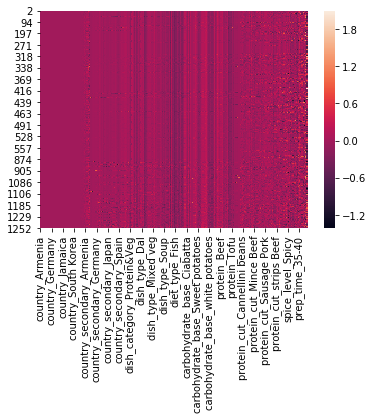

In [158]:
df_transformed
ax = sns.heatmap(df_transformed)

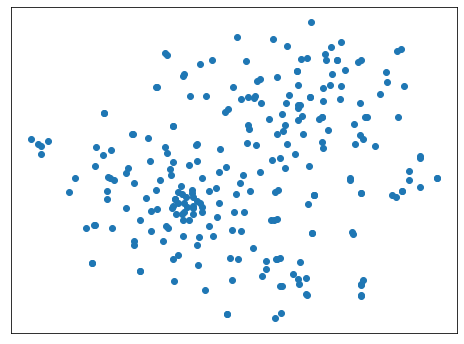

In [159]:
from sklearn.manifold import TSNE

def plot_tsne(X, y=None, colormap=plt.cm.Paired):
    plt.figure(figsize=(8, 6))

    # clean the figure
    plt.clf()

    tsne = TSNE()
    X_embedded = tsne.fit_transform(X)
    if y==None:
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], cmap=colormap)
    else:
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=colormap)
        

    plt.xticks(())
    plt.yticks(())

    plt.show()
    
# show a brief vizualization of the new, transformed dataset using dimensionality reduction.
plot_tsne(df_transformed)

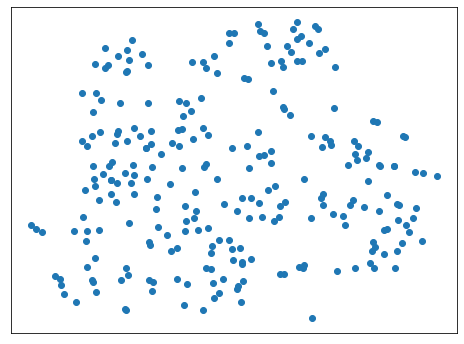

In [160]:
# dataset prior to metric learning, simply out of curiosity
plot_tsne(df_dummy)

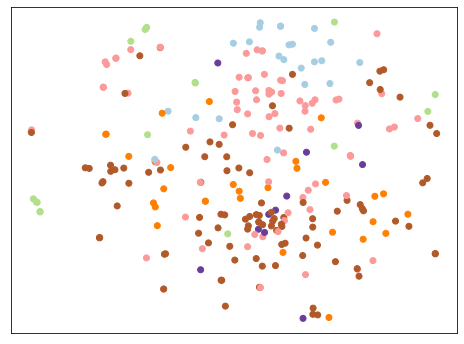

In [161]:
# plot with some coloring based on a crude dish category for curiousity. Some clusters are highlighted
plot_tsne(df_transformed, df_recipes.dish_category.values.tolist())

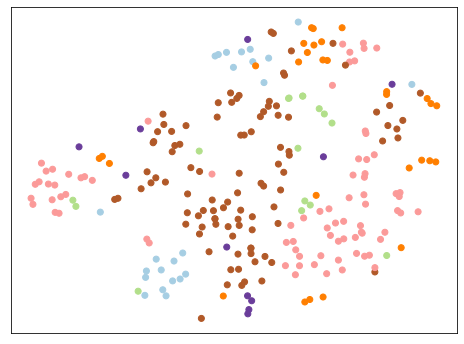

In [162]:
# clusters based on a single variable highlight are probably more obvious in the raw data
plot_tsne(df_dummy, df_recipes.dish_category.values.tolist())

## Construct similarity matrix using Mahalanobis Distances

In [253]:

results = []

for index, row in df_transformed.iterrows():
    pairs = []
    for index_inner, row_inner in df_transformed.iterrows():
        inner_array = [row.values.tolist(), row_inner.values.tolist()]
        pairs.append(inner_array)
    results.append(mmc.decision_function(pairs))
    
    # print(result_array)
    

In [255]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

for i in range(0, len(results)):
    results = scaler.fit_transform(results)

df_similar = pd.DataFrame(
        data=results,
        columns=df_recipes.recipe_id.values,
        index=df_recipes.recipe_id.values
    )

In [258]:
df_similar

,2,5,9,16,19,20,30,53,54,57,...,1270,1276,1277,1278,1279,1280,1281,1282,1283,1284
2,1.000000,0.217462,0.546947,0.174807,0.283408,0.290107,0.315476,0.288003,0.388200,0.479265,...,0.144872,0.051932,0.093730,0.388042,0.352340,0.121427,0.601164,0.237428,0.358476,0.193550
5,0.296538,1.000000,0.343451,0.294353,0.259869,0.405525,0.402372,0.239565,0.326353,0.399862,...,0.275944,0.407569,0.390549,0.271773,0.257758,0.317922,0.420921,0.198659,0.323466,0.343439
9,0.590584,0.339993,1.000000,0.265409,0.360538,0.403966,0.433392,0.352471,0.480896,0.599341,...,0.215421,0.187913,0.227446,0.290509,0.535469,0.193395,0.470748,0.257652,0.454059,0.301973
16,0.274190,0.309569,0.285015,1.000000,0.277476,0.394342,0.306349,0.250467,0.301046,0.356400,...,0.446310,0.270021,0.227929,0.308524,0.210574,0.251086,0.271368,0.240141,0.286607,0.245809
19,0.281979,0.175029,0.290972,0.176905,1.000000,0.422591,0.264087,0.316472,0.346389,0.393228,...,0.116479,0.086865,0.116165,0.121306,0.176664,0.149282,0.226542,0.289339,0.248779,0.183828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,0.081977,0.207180,0.067348,0.110308,0.112852,0.138952,0.052305,0.045477,0.075072,0.082874,...,0.106563,0.188944,0.357645,0.107699,0.031205,1.000000,0.072611,0.074190,0.055667,0.205904
1281,0.629863,0.402180,0.456482,0.231208,0.283627,0.369707,0.484998,0.357125,0.456357,0.444811,...,0.233070,0.206486,0.212937,0.474721,0.343883,0.176328,1.000000,0.285952,0.425468,0.221284
1282,0.144542,0.000000,0.078471,0.030868,0.204363,0.157487,0.341375,0.228746,0.435459,0.200465,...,0.124257,0.037028,0.000000,0.033852,0.017116,0.006052,0.136868,1.000000,0.301705,0.000000
1283,0.367432,0.257923,0.404306,0.200247,0.260740,0.341638,0.556489,0.351576,0.587921,0.416073,...,0.160606,0.155636,0.159122,0.163970,0.242076,0.108863,0.389563,0.386216,1.000000,0.151364
